# Lab 11 - Finding the Rumor Source
edo

In this lab, you will learn how to design **message passing** algorithms to locate the source of a rumor in a given network. 

After filling this notebook and running all the cells, rename the file **lab11.ipynb** to **netid_lab11.ipynb**, include your **well commented** code, and submit it by email. Avoid unneeded steps/computations and make sure your code runs before submitting it. Grading is based on your submission which is due at **9 p.m. Nov 28, 2017**. There is no late policy. No late submissions will be accepted.

**You will need the following functions from Lab 10.**

In [1]:
%matplotlib inline
from pylab import *
import random as rnd
import networkx as nx
from __future__ import division
import copy

rcParams['figure.figsize'] = 12, 12  # that's default image size for this interactive session

def draw_graph(graph, labels=None, graph_layout='shell',
               node_size=1600, node_color='blue', node_alpha=0.3,
               node_text_size=12,
               edge_color='blue', edge_alpha=0.3, edge_tickness=1,
               edge_text_pos=0.3,
               text_font='sans-serif'):
    """ 
    Based on: https://www.udacity.com/wiki/creating-network-graphs-with-python
    We describe a graph as a list enumerating all edges.
    Ex: graph = [(1,2), (2,3)] represents a graph with 2 edges - (node1 - node2) and (node2 - node3)
    """
    
    # create networkx graph
    G=nx.Graph()

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(G)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(G)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(G)
    else:
        graph_pos=nx.shell_layout(G)

    # draw graph
    nx.draw_networkx_nodes(G,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(G,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    nx.draw_networkx_labels(G, graph_pos,font_size=node_text_size,
                            font_family=text_font)
    # show graph
    plt.show()
    
def build_adjacency(filename, min_degree, num_nodes):
    
    adjacency = [[] for i in range(num_nodes)]
    
    f = open(filename, 'r')
    # determine the degree number for each node
    for line in f.readlines():
        u, v, _, _  = map(int, line.split())
        # index from 1 in the file but from 0 in the list
        u -= 1
        v -= 1
        if u < num_nodes and v < num_nodes:
            adjacency[u].append(v)
            adjacency[v].append(u)
        if u >= num_nodes:
            break
    f.close()
    num_degrees = map(len, adjacency)
    filter_nodes = filter(lambda x: len(adjacency[x]) < min_degree, range(num_nodes))
    for i, neighbor in enumerate(adjacency):
        # if this node has less than min_degree neighbors
        if i in filter_nodes:
            neighbor = []
        # remove all nodes that has less than min_degree neighbors from current neighbors
        else:
            neighbor = filter(lambda x: x not in filter_nodes, neighbor)
        adjacency[i] = neighbor
    return adjacency

def adjacency_to_graph(adjacency):
    graph = []
    for u, neighbor in enumerate(adjacency):
        u += 1
        for v in neighbor:
            v += 1
            if v >= u: # avoid duplicate since u is in v's neighbor and v is in u's neighbor
                graph.append((u, v))            
    return graph

def generate_source(adjacency):
    while True:
        source = rnd.randint(0, len(adjacency) - 1)
        if len(adjacency[source]) > 0:
            break
    return source

def si_model_rumor_spreading(source, adjancency, N):
    infected_nodes = [-1]*N;
    who_infected = [[] for i in range(N)]
    
    # adding the source node to the list of infected nodes
    infected_nodes[0] = source
    
    for i in range(1,N):
        
        # update the set of susceptible_nodes and its corresponding source
        susceptible_nodes = []
        source_indices = []
        for source_new_idx, source_original_idx in enumerate(infected_nodes[:i]):
            neighbors = adjacency[source_original_idx]
            for neighbor in neighbors:
                # only susceptible when it's not infected yet
                if neighbor not in infected_nodes:
                    susceptible_nodes.append(neighbor)
                    source_indices.append(source_new_idx)
        
        # randomly generated a node from the set of all susceptible nodes
        rnd_idx = rnd.randrange(len(susceptible_nodes))
        to_be_infected_node_original_index = susceptible_nodes[rnd_idx]
        source = source_indices[rnd_idx]
        # store its original index in the infected_nodes
        infected_nodes[i] = to_be_infected_node_original_index
        # update the subgraph
        who_infected[i] = [source]
        who_infected[source].append(i)


    return who_infected, infected_nodes
    

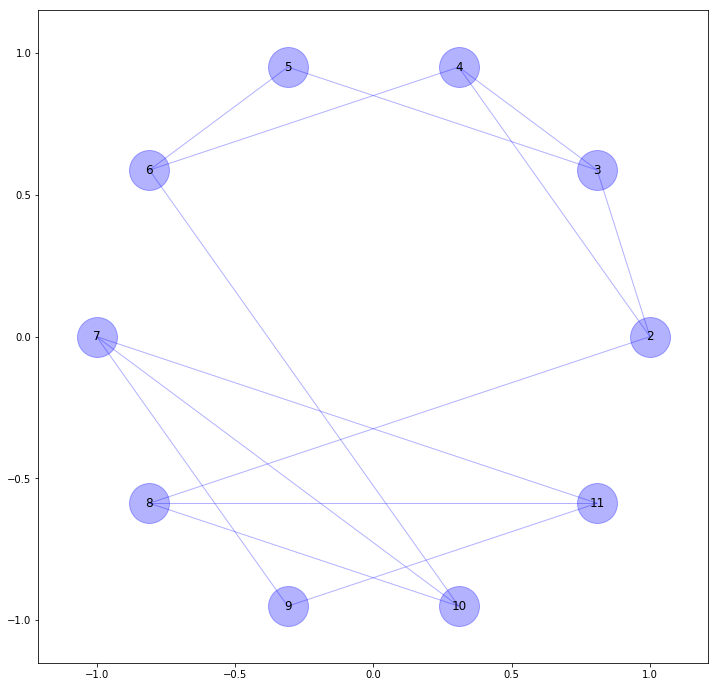

In [2]:
adjacency = [ [] for i in range(11)]
adjacency[0] = []
adjacency[10] = [6, 7, 8]
adjacency[1] = [2, 3, 7]
adjacency[2] = [1, 3, 4]
adjacency[9] = [5, 6, 7]
adjacency[3] = [1, 2, 5]
adjacency[4] = [2, 5]
adjacency[5] = [3, 9]
adjacency[6] = [8, 9, 10]
adjacency[7] = [1, 9, 10]
adjacency[8] = [6, 10]
adjacency[9] = [5, 6, 7]

graph = adjacency_to_graph(adjacency)
draw_graph(graph)


----

## Problem 0: Graph Traversal (0 pts)

Assume that you are given the adjacency list of a tree. Choose any node in the adjacency list to be the root of the tree. Write down a function called `upward_pass` that accepts the adjacency list and root node as arguments and does the following. It uses a recursive depth first search (DFS) traversal algorithm to pass messages from the leaf nodes up to the root node. The leaf nodes should pass 1 to their parent nodes. Intermediate nodes should sum the incoming messages, increment the sum by 1, and then pass the final result to their parent node. The algorithm stops whenever you hit the chosen root node. The function should return the list of values that were passed by each node in the tree.

In [3]:
def message_passing_up(up_messages, who_infected, parent_node, current_node):
    # root:
    if current_node == parent_node:
        for child_node in who_infected[current_node]:
            up_messages = message_passing_up(up_messages, who_infected, current_node, child_node)
    elif len(who_infected[current_node]) == 1:
        up_messages[parent_node] += 1
    # leave 
    else:
        for child_node in who_infected[current_node]:
            if child_node != parent_node:
                up_messages = message_passing_up(up_messages, who_infected, current_node, child_node)
        up_messages[parent_node] += up_messages[current_node]
    return up_messages
        
# creating a toy graph (tree)
adjacency = [ [] for i in range(7)]
adjacency[0] = [1, 2]
adjacency[1] = [0, 3, 4]
adjacency[2] = [0, 5]
adjacency[3] = [1]
adjacency[4] = [1]
adjacency[5] = [2,6]
#adjacency[6] = [2]
adjacency[6] = [5]

root_node = 2 # can use any arbitrary index for the root node
up_messages = [1]*len(adjacency) 
messages = message_passing_up(up_messages, adjacency, root_node, root_node)
print messages

[4, 3, 7, 1, 1, 2, 1]


----

## Problem 1: Rumor Centrality (35 pts)

In [5]:
math.log(math.factorial(6000))/6

7700.392866509558

Use the code provided in problem 0 to complete the functions below.

In [6]:
import math
def rumor_centrality_up(up_messages, who_infected, parent_node, current_node):
    
    # your code goes here
    #message_passing_up(up_messages, adjacency, root_node, root_node)
    if current_node == parent_node:
        for child_node in who_infected[current_node]:
            up_messages = rumor_centrality_up(up_messages, who_infected, current_node, child_node)
    elif len(who_infected[current_node]) == 1:
        up_messages[parent_node][0] += 1
        up_messages[parent_node][1]=up_messages[parent_node][1]*up_messages[current_node][1]
    # leave 
    else:
        for child_node in who_infected[current_node]:
            if child_node != parent_node:
                up_messages = rumor_centrality_up(up_messages, who_infected, current_node, child_node)
                up_messages[current_node][1]=up_messages[current_node][1]*up_messages[child_node][1]
        up_messages[parent_node][0] += up_messages[current_node][0]
        up_messages[current_node][1]= up_messages[current_node][0]*up_messages[current_node][1]
    return up_messages


def rumor_centrality_down(down_messages, up_messages, who_infected, parent_node, current_node):
    
    # your code goes here
    if current_node == parent_node:
        down_messages[current_node] = math.log(math.factorial(len(who_infected)))-math.log((len(who_infected)))
        for child_node in who_infected[current_node]:
            down_messages[current_node]= down_messages[current_node]-math.log((up_messages[child_node][1]))
        for child_node in who_infected[current_node]:
            down_messages=rumor_centrality_down(down_messages, up_messages, who_infected, current_node, child_node)
    else:
        down_messages[current_node]=(down_messages[parent_node]+math.log(up_messages[current_node][0]))-(math.log((len(who_infected)-up_messages[current_node][0])))
        for child_node in who_infected[current_node]:
            if child_node != parent_node:
                down_messages=rumor_centrality_down(down_messages, up_messages, who_infected, current_node, child_node)
    return down_messages


def rumor_centrality(who_infected):
    root_node=2
    rumor_center = -1
    # your code goes here
    up_messages=[]
    for i in range(len(who_infected)):
        up_messages.append([1,1])  
    down_messages=[1]*len(who_infected)                                                                                                
    up_message=rumor_centrality_up(up_messages, who_infected, root_node, root_node)
    down_message=rumor_centrality_down(down_messages, up_message, who_infected, root_node, root_node)
    center=max(down_message)
    for i in range(len(down_messages)):
        if down_messages[i]==center:
            rumor_center=i

    return rumor_center


In [7]:
rumor_centrality(adjacency)

0

----

## Problem 3: Jordan Centrality (35 pts)

Use the code provided in problem 0 to complete the functions below.

In [8]:
def jordan_centrality_up(up_messages, who_infected, parent_node, current_node):
    
    # your code goes here
    if current_node == parent_node:
        for child_node in who_infected[current_node]:
            up_messages = jordan_centrality_up(up_messages, who_infected, current_node, child_node)
    elif len(who_infected[current_node]) == 1:
        up_messages[parent_node][0] =max( up_messages[parent_node][0] ,(up_messages[current_node][0]+1))
        if len(who_infected[parent_node])>=3:
            up_messages[parent_node][1]=up_messages[current_node][1]+1
    # leave 
    else:
        for child_node in who_infected[current_node]:
            if child_node != parent_node:
                up_messages = jordan_centrality_up(up_messages, who_infected, current_node, child_node)
                #up_messages[parent_node][1]=up_messages[parent_node][1]*up_messages[child_node][1]
        up_messages[parent_node][0]=max( up_messages[parent_node][0] ,(up_messages[current_node][0]+1))
        if len(who_infected[parent_node])>=3:
            up_messages[parent_node][1]=up_messages[current_node][0]+1
        #up_messages[parent_node][1]=up_messages[parent_node][0]*up_messages[parent_node][1]
    return up_messages


def jordan_centrality_down(down_messages, who_infected, parent_node, current_node,centre):
    if current_node == parent_node: 
        if (down_messages[parent_node][0]-down_messages[parent_node][1])>1:
            for child_node in who_infected[current_node]:
                    down_messages[child_node][1]=max(down_messages[child_node][1], down_messages[current_node][1]+1)      
                    down_messages,centre=jordan_centrality_down(down_messages, who_infected, current_node,child_node,centre)
        else:
            c=copy.deepcopy(current_node)
            centre=c
            return down_messages,centre
    else:
        for child_node in who_infected[current_node]:
            if child_node != parent_node:
                if (down_messages[current_node][0]-down_messages[current_node][1])>1:
                    down_messages[child_node][1]=max(down_messages[child_node][1], down_messages[current_node][1]+1)      
                    down_messages,centre=jordan_centrality_down(down_messages, who_infected, current_node,child_node,centre)
                else:
                    c=copy.deepcopy(current_node)
                    centre=c
                    return down_messages,centre
    return down_messages,centre

def jordan_centrality(who_infected):
    root_node=3
    up_messages=[]
    for i in range(len(who_infected)):
        up_messages.append([0,0])
    jordan_center = -1
    up_message=jordan_centrality_up(up_messages, who_infected, root_node, root_node)
    down_message,jordan_center=jordan_centrality_down(up_message, who_infected, root_node, root_node,root_node)
    return jordan_center

print jordan_centrality(adjacency)

0


----

## Problem 4: Putting it All Together (30 pts)

Use the function `buildDatasetGraph` with `filename = out.facebook-wosn-links`, `num_nodes = 4941`, and `min_degree = 3` to load Facebook's social network.  After loading the social network, use the SI spreading model developed in Lab 6 to generate an infected subgraph of size $N$ (a parameter that will be specified in a bit). Estimate the source of the rumor using both rumor centrality (Problem 2) and Jordan centrality (Problem 3). For each case, the estimated rumor source $\hat{v}$ can be compared to the true rumor source $v^*$ to determine whether the detection was correct or wrong. This process can be repeated 1000 times in order to compute the **average probability of detection** $P_d(N)$ by counting the number of times we have $\hat{v}= v^*$ and dividing this number by 1000.


Consider $N=10:10:500$ and then for
each $N$ compute $P_d(N)$ (as described above) for both rumor centrality and Jordan centrality. The notation $N = 10 : 10 : 500$ is borrowed from MATLAB. It means $N = 10, 20, 30, 40, ...., 500$. So, $N$ goes from 10 to 500 in increments of 10. Plot $P_d(N)$ as a
function of $N$ (all on the same
figure) on a log-log scale.

**The above simulations will take a while (at least one hour) so make
sure you run them well before the deadline.**

/Users/shruti/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3245: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


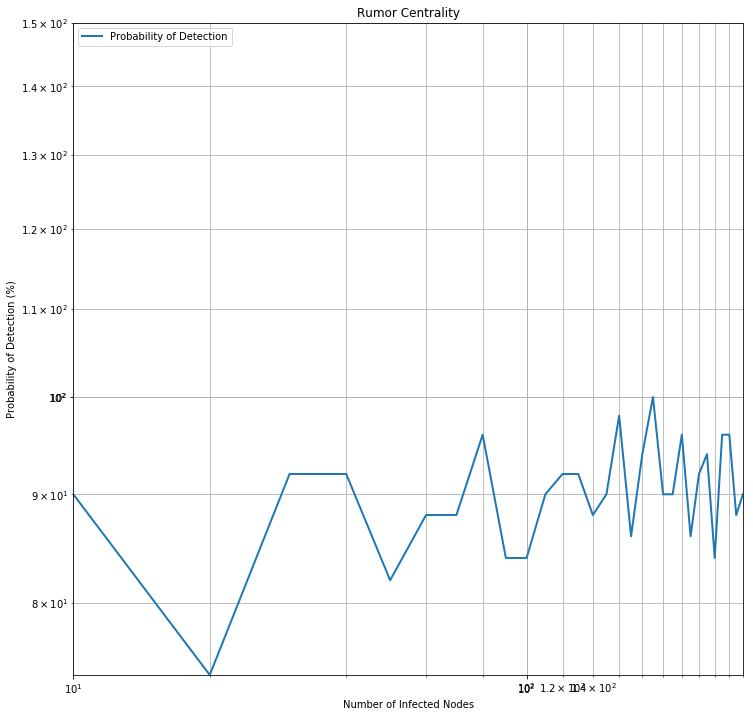

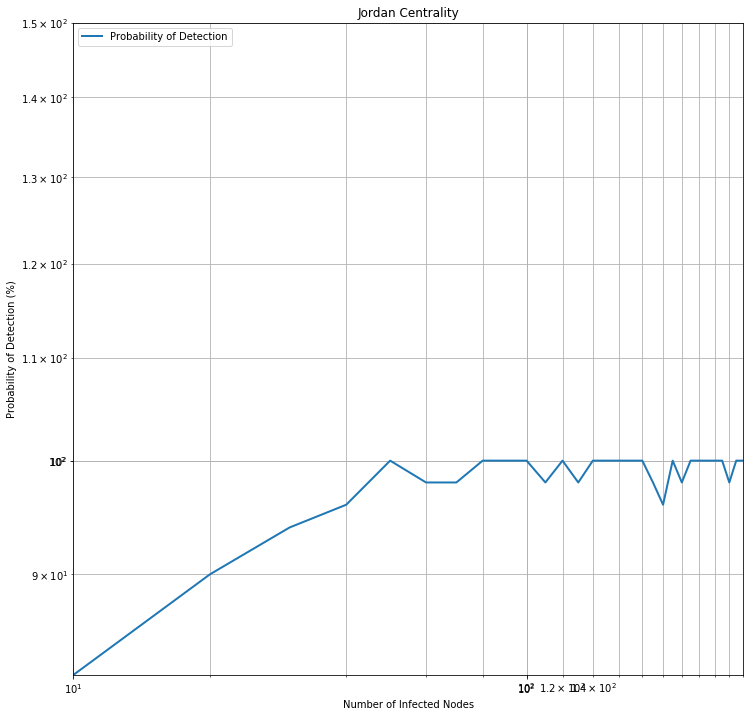

In [9]:
rnd.seed(233)

N_min = 10 # min number of nodes to infect
N_max = 300 # max number of nodes to infect
Inc = 10 # increment
L = 50 # number of trials

Pd_rumor = [] # initializing the detection probability list under rumor centrality to an empty list
Pd_jordan = [] # initializing the detection probability list under rumor centrality to an empty list
N_axis = []

# tweak this line to match the problem statement!
adjacency = build_adjacency('out.facebook-wosn-links.txt', 3, 4941)
num_nodes = len(adjacency) # number of nodes in the underlying graph (this includes nodes with no neighbours)

for N in range(N_min, N_max + 1, Inc):
    N_axis.append(N)
    det_count = 0 # initializing the detection counter to zero
    jordan_errors = 0 # this will keep track of the number of errors under rumor centrality
    rumor_errors = 0 # this will keep track of the number of errors under Jordan centrality

    for j in range(L):
        
        # select a rumor source at random
        while True:
            try:
                # select a rumor source at random
                source = generate_source(adjacency)
                # spread the rumor to N people and return who_infected (the adjacency list of the infection tree)
                who_infected, infected_nodes = si_model_rumor_spreading(source, adjacency, N)
                break
            except:
                continue
        # use rumor centrality to estimate the source
        r_center=rumor_centrality(who_infected)
        rumor_center=infected_nodes[r_center]
        
        # figure out if rumor center = rumor source and update rumor_errors correspondingly
        if rumor_center!=source :
            rumor_errors+=1
        # user Jordan centrality to estimate the source
        J_center=jordan_centrality(who_infected)
        Jordan_center=infected_nodes[J_center]
        # figure out if Jordan center = rumor source and update jordan_errors correspondingly
        if Jordan_center!=source :
            jordan_errors+=1
            

    Pd_rumor.append(float(rumor_errors)/L)
    Pd_jordan.append(float(jordan_errors)/L)

# tweak this code to (a) be a log-log plot and (b) include the jordan centrality probability of error
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
ax = plt.subplot(111)
plt.loglog(N_axis, [y * 100 for y in Pd_rumor], lw = 2.0, label = "Probability of Detection")
plt.axis([N_min, N_max, 0, 150])
plt.xlabel("Number of Infected Nodes")
plt.ylabel("Probability of Detection (%)")
plt.legend(loc = "upper left")
plt.title("Rumor Centrality")
plt.grid(which = "minor")
plt.grid(which = "major")
ax.xaxis.set_minor_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(MultipleLocator(10))
plt.show()
ax1 = plt.subplot(111)
plt.loglog(N_axis, [y * 100 for y in Pd_jordan], lw = 2.0, label = "Probability of Detection")
plt.axis([N_min, N_max, 0, 150])
plt.xlabel("Number of Infected Nodes")
plt.ylabel("Probability of Detection (%)")
plt.legend(loc = "upper left")
plt.title("Jordan Centrality")
plt.grid(which = "minor")
plt.grid(which = "major")
ax1.xaxis.set_minor_locator(MultipleLocator(20))
ax1.yaxis.set_minor_locator(MultipleLocator(10))
plt.show()

**Questions**

- How does $P_d(N)$ vary as a function of $N$ under Jordan and rumor centrality? Why? 
    
    for Jordon centrality the log-log plot is almost linear therfore the probailty of Jordon errors increases exponentially with the increase in infected nodes.
    For rumor centrality as well as number of nodes increases in genereal the probablity of error in source detection increases but it is not as consisitent as in Jordon centrality.
    Therfore, $P_d(N)$ is increasing with N makes sense as the infected nodes increases it become more difficult to find the source node. 


- Is Jordan centrality better than rumor centrality? Why? 

I think rumor cenrtrality is better bacause it had less error rate(probability of error) in finding the source of infected nodes compared to the Jordan centre.
In Jordon centrality the probability of error almost remained close to 100% if infecetd nodes incresed beyond 100. Whereas for rumor centrality it was between 80 to 100% if infected nodes were increased beyond 100.
I think since Jordon centrality is based on max possible length of a node from any of the leaf nodes, as the infected nodes increase there can be more nodes having the same maximum Jordon length. thus more prone to error if infected nodes increase.

In rumor centrality , a node in a tree has higher probabilty to be the centre depending on how many diffrent ways it can infect all its children nodes and their child nodes until leaf node is obtained. therefore it is more accurate in obtaining the source.
